# * Postpaid B2B Performance *

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
''' Config '''

config = configparser.ConfigParser()
config.read('../../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']
v_product = 'Postpaid B2B'

In [3]:
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 
        'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
# postpaid_rev_cd_list = ['B2R000100', 'B2R000101', 'B2R000102'] # 'Postpaid Revenue', 'Postpaid New Revenue', 'Postpaid Existing Revenue'
postpaid_b2b_rev_cd_list = ['B2R020100', 'DB2R020100', 'TB2R020100'] # 'Postpaid Revenue B2B', 'Postpaid Revenue B2B : DTAC', 'Postpaid Revenue B2B : TMH'

postpaid_b2b_activation_cd_list = ['B2S020100', 'DB2S020100', 'TB2S020100'] # 'Postpaid Activation Subs B2B', 'Postpaid Activation Subs B2B : DTAC', 'Postpaid Activation Subs B2B : TMH'

postpaid_b2b_chrn_cd_list = ['B2S020200', 'DB2S020200', 'TB2S020200'] # 'Postpaid Churn Subs B2B', 'Postpaid Churn Subs B2B : DTAC', 'Postpaid Churn Subs B2B : TMH'

postpaid_b2b_netadd_cd_list = ['B2S020300', 'DB2S020300', 'TB2S020300'] # 'Postpaid Net Add B2B', 'Postpaid Net Add B2B : DTAC', 'Postpaid Net Add B2B : TMH'

''' Filter Metric CD List '''
postpaid_all_rev_cd_list = postpaid_b2b_rev_cd_list
postpaid_all_activation_cd_list = postpaid_b2b_activation_cd_list
postpaid_all_chrn_cd_list = postpaid_b2b_chrn_cd_list
postpaid_all_netadd_cd_list = postpaid_b2b_netadd_cd_list

postpaid_all_use_cd_list = postpaid_all_rev_cd_list + postpaid_all_activation_cd_list + postpaid_all_chrn_cd_list + postpaid_all_netadd_cd_list

In [4]:
df.shape

(41153, 24)

In [5]:
''' Find Metric '''

df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND'])\
    .agg({'ACTUAL_SNAP': 'sum', 'ACTUAL_AGG': 'sum', 'TARGET_SNAP': 'sum', 'TARGET_AGG': 'sum', 'BASELINE_SNAP':'sum', 'BASELINE_AGG':'sum', 'TM_KEY_DAY':'max'}).reset_index()
# df_agg_n = df.loc[df[(df['AGG_TYPE']=='N') & (df['ACTUAL_SNAP']>0)].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'GRY_IND', 
                     'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'TM_KEY_DAY']]
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric = df_metric.rename(columns={'TM_KEY_DAY':'MAX_DAY'})
df_metric['ACTUAL_SNAP'] = df_metric['ACTUAL_SNAP'] / 1000000
df_metric['ACTUAL_AGG'] = df_metric['ACTUAL_AGG'] / 1000000
df_metric['TARGET_SNAP'] = df_metric['TARGET_SNAP'] / 1000000
df_metric['TARGET_AGG'] = df_metric['TARGET_AGG'] / 1000000
df_metric['BASELINE_SNAP'] = df_metric['BASELINE_SNAP'] / 1000000
df_metric['BASELINE_AGG'] = df_metric['BASELINE_AGG'] / 1000000
# df_metric

''' Filters '''
df_tmp = df_metric[df_metric['PRODUCT_GRP']=="Postpaid"]
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['COMP_CD']=="ALL"]
# df_tmp = df_tmp[df_tmp['COMP_CD']=="DTAC"]
# df_tmp = df_tmp[df_tmp['COMP_CD']=="TRUE"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("B2B")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Activation Sub")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Churn Subs")]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Net Add")]
df_tmp = df_metric[df_metric['METRIC_CD'].isin(postpaid_all_use_cd_list)]
df_tmp = df_tmp.sort_values(by=['CENTER', 'METRIC_GRP', 'COMP_CD', 'METRIC_CD']).reset_index()

# df_tmp.to_excel('Raw-Postpaid_Metric.xlsx', index=False)
df_tmp

,index,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,GRY_IND,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,BASELINE_SNAP,BASELINE_AGG,MAX_DAY
0,10,Customer Service Experience & Retention,Retention & Churn,ALL,Postpaid,B2S020200,Postpaid Churn Subs B2B,S,RYG,0.109669,1.662032,0.099812,1.518901,0.102630,1.579665,20230718
1,16,Customer Service Experience & Retention,Retention & Churn,DTAC,Postpaid,DB2S020200,Postpaid Churn Subs B2B : DTAC,S,RYG,0.049607,0.675011,0.055173,0.834688,0.022878,0.366048,20230718
2,24,Customer Service Experience & Retention,Retention & Churn,TRUE,Postpaid,TB2S020200,Postpaid Churn Subs B2B : TMH,S,RYG,0.060111,0.987168,0.045042,0.685422,0.081537,1.217187,20230718
3,40,Sales & Revenue,Revenue,ALL,Postpaid,B2R020100,Postpaid Revenue B2B,S,GYR,2733.722204,53497.182776,3281.948073,62012.960462,0.000000,0.000000,20230718
4,53,Sales & Revenue,Revenue,DTAC,Postpaid,DB2R020100,Postpaid Revenue B2B : DTAC,S,GYR,911.455381,22039.461124,989.385940,23993.774869,0.000000,0.000000,20230718
5,65,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R020100,Postpaid Revenue B2B : TMH,S,GYR,1822.266822,31457.721653,1476.141695,25120.272995,0.000000,0.000000,20230718
6,90,Sales & Revenue,Sales,ALL,Postpaid,B2S020100,Postpaid Activation Subs B2B,S,GYR,0.117058,1.789927,0.000000,0.000000,0.000000,0.000000,20230718
7,103,Sales & Revenue,Sales,DTAC,Postpaid,DB2S020100,Postpaid Activation Subs B2B : DTAC,S,GYR,0.049598,0.675607,0.000000,0.000000,0.000000,0.000000,20230718
8,118,Sales & Revenue,Sales,TRUE,Postpaid,TB2S020100,Postpaid Activation Subs B2B : TMH,S,GYR,0.067473,1.114346,0.030439,0.458227,0.000000,0.000000,20230718


## Data Preporation

In [6]:
''' Functions '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

def unit_k(baht):
    n = baht
    unit_k = n / 1000
    return unit_k

In [7]:
''' Rawdata '''

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202306] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230710] # DAY filter
df = df[df['METRIC_CD'].isin(postpaid_all_use_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG', 'BASELINE_SNAP':'BL_SNAP', 'BASELINE_AGG':'BL_AGG'})

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,BL_SNAP,BL_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
19870,20230716,2023028,202307,20233,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R020100,...,33184854.47,2.467329e+08,2.603830e+07,1.957714e+08,NaN,0.0,2023-07-19 06:49:13,July,28,16
19871,20230717,2023029,202307,20233,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R020100,...,NaN,2.467329e+08,NaN,1.957714e+08,NaN,0.0,2023-07-19 06:49:13,July,29,17
19872,20230718,2023029,202307,20233,2023,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R020100,...,NaN,2.467329e+08,NaN,1.957714e+08,NaN,0.0,2023-07-19 06:49:13,July,29,18


In [8]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']
df_agg_s = df_agg_s.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')
df_agg_n = df_agg_n.rename(columns={'ACT_SNAP':'ACT', 'TGT_SNAP':'TGT', 'BL_SNAP':'BL'})

In [9]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [10]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 
            'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG', 'BL_SNAP', 'BL_AGG']
df_day = df[cols_agg].reset_index()

''' Aggregation '''
df_day['ACT'] = np.where(df_day['AGG_TYPE']=='N', df_day['ACT_AGG'], df_day['ACT_SNAP'])
df_day['TGT'] = np.where(df_day['AGG_TYPE']=='N', df_day['TGT_AGG'], df_day['TGT_SNAP'])
df_day['%ACHV'] = np.where(df_day['METRIC_NAME'].str.contains("Churn"), -((df_day['ACT']/df_day['TGT'])-1), df_day['ACT']/df_day['TGT']) 
df_day['GAP'] = df_day['ACT'] - df_day['TGT']
df_day['LAST_ACT'] = df_day.groupby('METRIC_CD')['ACT'].shift()
df_day['DIFF'] = df_day['ACT'] - df_day['LAST_ACT']
df_day['%DOD'] = (df_day['ACT'] / df_day['LAST_ACT']) - 1

# df_day.to_excel('df_day.xlsx', index=False)
df_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,TGT_AGG,BL_SNAP,BL_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
1257,19870,TB2R020100,Postpaid Revenue B2B : TMH,20230716,2023028,202307,20233,2023,July,16,...,1.957714e+08,NaN,0.0,33184854.47,2.603830e+07,1.274463,7.146559e+06,NaN,NaN,NaN
1258,19871,TB2R020100,Postpaid Revenue B2B : TMH,20230717,2023029,202307,20233,2023,July,17,...,1.957714e+08,NaN,0.0,NaN,NaN,NaN,NaN,33184854.47,NaN,NaN
1259,19872,TB2R020100,Postpaid Revenue B2B : TMH,20230718,2023029,202307,20233,2023,July,18,...,1.957714e+08,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Revenue B2B': 'REV_TOTAL', 'Postpaid Revenue B2B : DTAC': 'REV_DTAC', 'Postpaid Revenue B2B : TMH': 'REV_TMH', 
             'Postpaid Activation Subs B2B': 'ACTIVATION_TOTAL', 'Postpaid Activation Subs B2B : DTAC': 'ACTIVATION_DTAC', 'Postpaid Activation Subs B2B : TMH': 'ACTIVATION_TMH', 
             'Postpaid Churn Subs B2B': 'CHRN_TOTAL', 'Postpaid Churn Subs B2B : DTAC': 'CHRN_DTAC', 'Postpaid Churn Subs B2B : TMH': 'CHRN_TMH', 
             'Postpaid Net Add B2B': 'NET_ADD_TOTAL', 'Postpaid Net Add B2B : DTAC': 'NET_ADD_DTAC', 'Postpaid Net Add B2B : TMH': 'NET_ADD_TMH'}

In [12]:
''' Pivot by KPIS '''

df_day_agg = df_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index() 
df_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
137           20230716   2023028     202307      20233      2023     July   
138           20230717   2023029     202307      20233      2023     July   
139           20230718   2023029     202307      20233      2023     July   

            DAY_LABEL              ACT                                 ...  \
METRIC_NAME           ACTIVATION_TOTAL ACTIVATION_DTAC ACTIVATION_TMH  ...   
137                16             43.0             8.0           35.0  ...   
138                17              NaN             NaN           13.0  ...   
139                18              NaN             NaN            NaN  ...   

               DIFF             %DOD                                 \
METRIC_NAME REV_TMH ACTIVATION_TOTAL ACTIVATION_DTAC ACTIVATION_TMH   
137             NaN        -0.188679            -0.2      -0.186047   
138             NaN              NaN             NaN      -0.628571   
139             NaN              NaN             NaN            NaN   

                                                                        
METRIC_NAME CHRN_TOTAL CHRN_DTAC CHRN_TMH  REV_TOTAL  REV_DTAC REV_TMH  
137                NaN  7.166667      NaN  52.139685 -0.240088     NaN  
138                NaN       NaN      NaN        NaN       NaN     NaN  
139                NaN       NaN      NaN        NaN       NaN     NaN  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [13]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT', 'TGT']]
df_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_yr['%ACHV'] = np.where(df_yr['METRIC_NAME'].str.contains("Churn"), -((df_yr['ACT']/df_yr['TGT'])-1), df_yr['ACT']/df_yr['TGT']) 
df_yr['GAP'] = df_yr['ACT'] - df_yr['TGT']
df_yr['LAST_ACT'] = df_yr.groupby('METRIC_CD')['ACT'].shift()
df_yr['DIFF'] = df_yr['ACT'] - df_yr['LAST_ACT']
df_yr['%YOY'] = (df_yr['ACT'] / df_yr['LAST_ACT']) - 1

# df_yr.to_excel('df_yr.xlsx')
df_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B2R020100,Postpaid Revenue B2B,2023,S,2.733722e+09,3.281948e+09,0.832957,-5.482259e+08,NaN,NaN,NaN
1,B2S020100,Postpaid Activation Subs B2B,2023,S,1.170580e+05,0.000000e+00,inf,1.170580e+05,NaN,NaN,NaN
2,B2S020200,Postpaid Churn Subs B2B,2023,S,1.096690e+05,9.981200e+04,-0.098756,9.857000e+03,NaN,NaN,NaN
3,DB2R020100,Postpaid Revenue B2B : DTAC,2023,S,9.114554e+08,9.893859e+08,0.921233,-7.793056e+07,NaN,NaN,NaN
4,DB2S020100,Postpaid Activation Subs B2B : DTAC,2023,S,4.959800e+04,0.000000e+00,inf,4.959800e+04,NaN,NaN,NaN
5,DB2S020200,Postpaid Churn Subs B2B : DTAC,2023,S,4.960700e+04,5.517300e+04,0.100883,-5.566000e+03,NaN,NaN,NaN
6,TB2R020100,Postpaid Revenue B2B : TMH,2023,S,1.822267e+09,1.476142e+09,1.234480,3.461251e+08,NaN,NaN,NaN
7,TB2S020100,Postpaid Activation Subs B2B : TMH,2023,S,6.747300e+04,3.043900e+04,2.216663,3.703400e+04,NaN,NaN,NaN
8,TB2S020200,Postpaid Churn Subs B2B : TMH,2023,S,6.011100e+04,4.504200e+04,-0.334554,1.506900e+04,NaN,NaN,NaN


In [14]:
''' Pivot by KPIS '''

df_yr_agg = df_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_yr_agg.tail(3)

TM_KEY_YR              ACT                                 \
METRIC_NAME           ACTIVATION_TOTAL ACTIVATION_DTAC ACTIVATION_TMH   
0                2023         117058.0         49598.0        67473.0   

                                                                       \
METRIC_NAME CHRN_TOTAL CHRN_DTAC CHRN_TMH     REV_TOTAL      REV_DTAC   
0             109669.0   49607.0  60111.0  2.733722e+09  9.114554e+08   

                           ...    DIFF             %YOY                  \
METRIC_NAME       REV_TMH  ... REV_TMH ACTIVATION_TOTAL ACTIVATION_DTAC   
0            1.822267e+09  ...     NaN              NaN             NaN   

                                                                             \
METRIC_NAME ACTIVATION_TMH CHRN_TOTAL CHRN_DTAC CHRN_TMH REV_TOTAL REV_DTAC   
0                      NaN        NaN       NaN      NaN       NaN      NaN   

                     
METRIC_NAME REV_TMH  
0               NaN  

[1 rows x 64 columns]

In [15]:
''' YTD Values '''

df_last_yr = df_day_agg[df_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT', 'TGT']]
day_cnt_curr_yr = len(df_day_agg[(df_day_agg['TM_KEY_YR']==curr_yr) & (df_day_agg['ACT']['REV_TOTAL']>0)]['TM_KEY_DAY'].unique())

ytd_last_act = (df_last_yr['ACT']['REV_TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_day_agg[df_day_agg['TM_KEY_YR']==curr_yr]['ACT']['REV_TOTAL'].sum()
ytd_tgt = df_day_agg[df_day_agg['TM_KEY_YR']==curr_yr]['TGT']['REV_TOTAL'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_10792\4017394259.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT']['REV_TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [16]:
''' Year Chart Values '''

x_yr = df_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Values '''
y_yr_act = df_yr_agg['ACT']['REV_TOTAL']
y_yr_act_dtac = df_yr_agg['ACT']['REV_DTAC']
y_yr_act_tmh = df_yr_agg['ACT']['REV_TMH']
y_yr_tgt = df_yr_agg['TGT']['REV_TOTAL']
y_yr_tgt_dtac = df_yr_agg['TGT']['REV_DTAC']
y_yr_tgt_tmh = df_yr_agg['TGT']['REV_TMH']
y_yr_achv = df_yr_agg['%ACHV']['REV_TOTAL']
y_yr_achv_dtac = df_yr_agg['%ACHV']['REV_DTAC']
y_yr_achv_tmh = df_yr_agg['%ACHV']['REV_TMH']
y_yr_gap = df_yr_agg['GAP']['REV_TOTAL']
y_yr_gap_dtac = df_yr_agg['GAP']['REV_DTAC']
y_yr_gap_tmh = df_yr_agg['GAP']['REV_TMH']
y_yr_diff = df_yr_agg['DIFF']['REV_TOTAL']
y_yr_diff_dtac = df_yr_agg['DIFF']['REV_DTAC']
y_yr_diff_tmh = df_yr_agg['DIFF']['REV_TMH']
y_yr_last_act = df_yr_agg['LAST_ACT']['REV_TOTAL']
y_yr_last_act_dtac = df_yr_agg['LAST_ACT']['REV_DTAC']
y_yr_last_act_tmh = df_yr_agg['LAST_ACT']['REV_TMH']
y_yr_yoy = df_yr_agg['%YOY']['REV_TOTAL']
y_yr_yoy_dtac = df_yr_agg['%YOY']['REV_DTAC']
y_yr_yoy_tmh = df_yr_agg['%YOY']['REV_TMH']

### YR : Visualizations

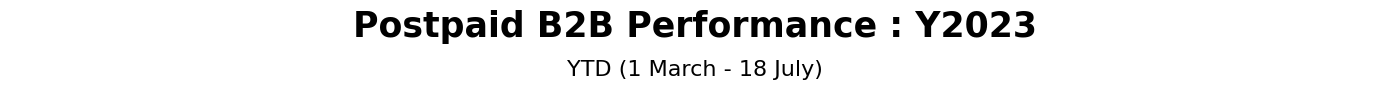

In [17]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

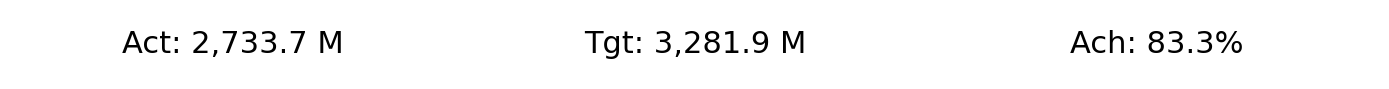

In [18]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(ytd_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(ytd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

fig.tight_layout()
plt.show()

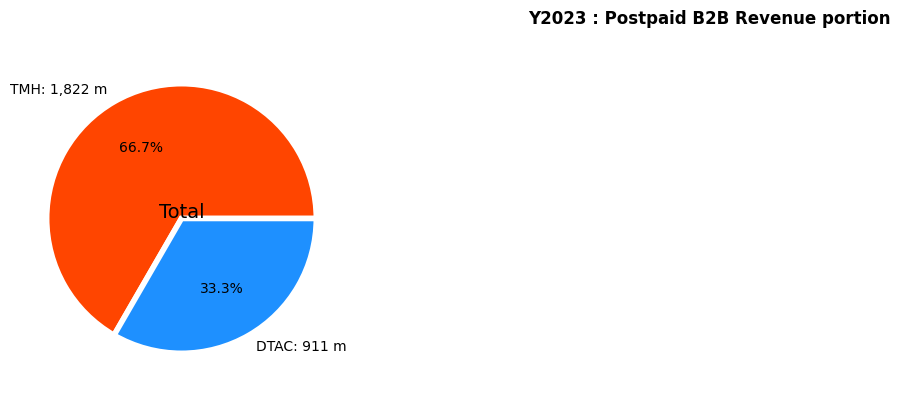

In [19]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} : {v_product} Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
# ax2 = fig.add_subplot(gs[:, 1])
# ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([unit_mb(y_yr_act_tmh.sum()), unit_mb(y_yr_act_dtac.sum())])
mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'Total', ha='center', fontsize=14)

# ''' ax2 '''
# y = np.array([unit_mb(y_yr_act_new_tmh.sum()), unit_mb(y_yr_act_new_dtac.sum())])
# mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
# mycolors = ["pink", "lightskyblue"]
# ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
# ax2.text(0, 0, 'New', ha='center', fontsize=14)

# ''' ax3 '''
# y = np.array([unit_mb(y_yr_act_exist_tmh.sum()), unit_mb(y_yr_act_exist_dtac.sum())])
# mylabels = [f"TMH: {format(y[0],',.0f')} m", f"DTAC: {format(y[1],',.0f')} m"]
# mycolors = ["pink", "lightskyblue"]
# ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
# ax3.text(0, 0, 'Existing', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [20]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT', 'TGT']]
df_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_mth['%ACHV'] = np.where(df_mth['METRIC_NAME'].str.contains("Churn"), -((df_mth['ACT']/df_mth['TGT'])-1), df_mth['ACT']/df_mth['TGT']) 
df_mth['GAP'] = df_mth['ACT'] - df_mth['TGT']
df_mth['LAST_ACT'] = df_mth.groupby('METRIC_CD')['ACT'].shift()
df_mth['DIFF'] = df_mth['ACT'] - df_mth['LAST_ACT']
df_mth['%MOM'] = (df_mth['ACT'] / df_mth['LAST_ACT']) - 1

# df_mth.to_excel('df_mth.xlsx')
df_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%MOM
40,TB2S020200,Postpaid Churn Subs B2B : TMH,202303,March,S,10500.0,9920.0,-0.058468,580.0,NaN,NaN,NaN
41,TB2S020200,Postpaid Churn Subs B2B : TMH,202304,April,S,10437.0,10020.0,-0.041617,417.0,10500.0,-63.0,-0.006000
42,TB2S020200,Postpaid Churn Subs B2B : TMH,202305,May,S,12615.0,9982.0,-0.263775,2633.0,10437.0,2178.0,0.208681
43,TB2S020200,Postpaid Churn Subs B2B : TMH,202306,June,S,10984.0,10080.0,-0.089683,904.0,12615.0,-1631.0,-0.129291
44,TB2S020200,Postpaid Churn Subs B2B : TMH,202307,July,S,15575.0,5040.0,-2.090278,10535.0,10984.0,4591.0,0.417972


In [21]:
''' Pivot by KPIS '''

df_mth_agg = df_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                          values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC              ACT                  \
METRIC_NAME                     ACTIVATION_TOTAL ACTIVATION_DTAC   
2               202305      May          21870.0         11539.0   
3               202306     June          22247.0          9943.0   
4               202307     July          12174.0          4509.0   

                                                                        \
METRIC_NAME ACTIVATION_TMH CHRN_TOTAL CHRN_DTAC CHRN_TMH     REV_TOTAL   
2                  10331.0    22790.0   10175.0  12615.0  5.761161e+08   
3                  12304.0    20245.0    9261.0  10984.0  5.948151e+08   
4                   7678.0    19823.0    4297.0  15575.0  4.139680e+08   

                           ...          DIFF             %MOM                  \
METRIC_NAME      REV_DTAC  ...       REV_TMH ACTIVATION_TOTAL ACTIVATION_DTAC   
2            1.903915e+08  ... -1.904121e+07        -0.329491       -0.069511   
3            1.942993e+08  ...  1.479117e+07         0.017238       -0.138314   
4            1.672351e+08  ... -1.537828e+08        -0.452780       -0.546515   

                                                                               \
METRIC_NAME ACTIVATION_TMH CHRN_TOTAL CHRN_DTAC  CHRN_TMH REV_TOTAL  REV_DTAC   
2                -0.488969   0.058376 -0.083003  0.208681 -0.009382  0.076834   
3                 0.190979  -0.111672 -0.089828 -0.129291  0.032457  0.020525   
4                -0.375975  -0.020845 -0.536011  0.417972 -0.304039 -0.139292   

                       
METRIC_NAME   REV_TMH  
2           -0.047043  
3            0.038346  
4           -0.383962  

[3 rows x 65 columns]

In [22]:
''' MTD Values '''

df_last_mth = df_day_agg[df_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT', 'TGT']]
day_cnt_curr_mth = len(df_day_agg[(df_day_agg['TM_KEY_MTH']==curr_mth) & (df_day_agg['ACT']['REV_TOTAL']>0)]['TM_KEY_DAY'].unique())

mtd_last_act = (df_last_mth['ACT']['REV_TOTAL'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth]['ACT']['REV_TOTAL'].sum()
mtd_tgt = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth]['TGT']['REV_TOTAL'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [23]:
''' Month Chart Values '''

x_mth = df_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Values '''
y_mth_act = df_mth_agg['ACT']['REV_TOTAL']
y_mth_act_dtac = df_mth_agg['ACT']['REV_DTAC']
y_mth_act_tmh = df_mth_agg['ACT']['REV_TMH']
y_mth_tgt = df_mth_agg['TGT']['REV_TOTAL']
y_mth_tgt_dtac = df_mth_agg['TGT']['REV_DTAC']
y_mth_tgt_tmh = df_mth_agg['TGT']['REV_TMH']
y_mth_achv = df_mth_agg['%ACHV']['REV_TOTAL']
y_mth_achv_dtac = df_mth_agg['%ACHV']['REV_DTAC']
y_mth_achv_tmh = df_mth_agg['%ACHV']['REV_TMH']
y_mth_gap = df_mth_agg['GAP']['REV_TOTAL']
y_mth_gap_dtac = df_mth_agg['GAP']['REV_DTAC']
y_mth_gap_tmh = df_mth_agg['GAP']['REV_TMH']
y_mth_diff = df_mth_agg['DIFF']['REV_TOTAL']
y_mth_diff_dtac = df_mth_agg['DIFF']['REV_DTAC']
y_mth_diff_tmh = df_mth_agg['DIFF']['REV_TMH']
y_mth_last_act = df_mth_agg['LAST_ACT']['REV_TOTAL']
y_mth_last_act_dtac = df_mth_agg['LAST_ACT']['REV_DTAC']
y_mth_last_act_tmh = df_mth_agg['LAST_ACT']['REV_TMH']
y_mth_mom = df_mth_agg['%MOM']['REV_TOTAL']
y_mth_mom_dtac = df_mth_agg['%MOM']['REV_DTAC']
y_mth_mom_tmh = df_mth_agg['%MOM']['REV_TMH']

### MTH : Visualizations

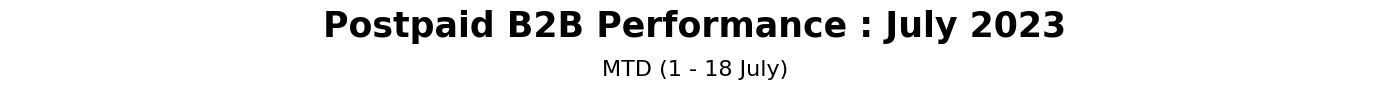

In [24]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

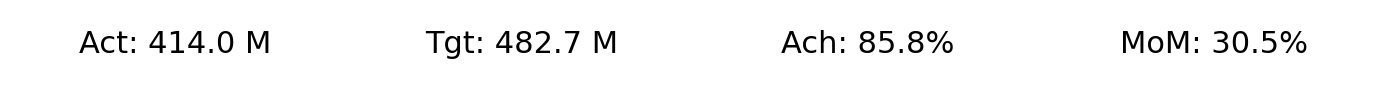

In [25]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(mtd_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(mtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

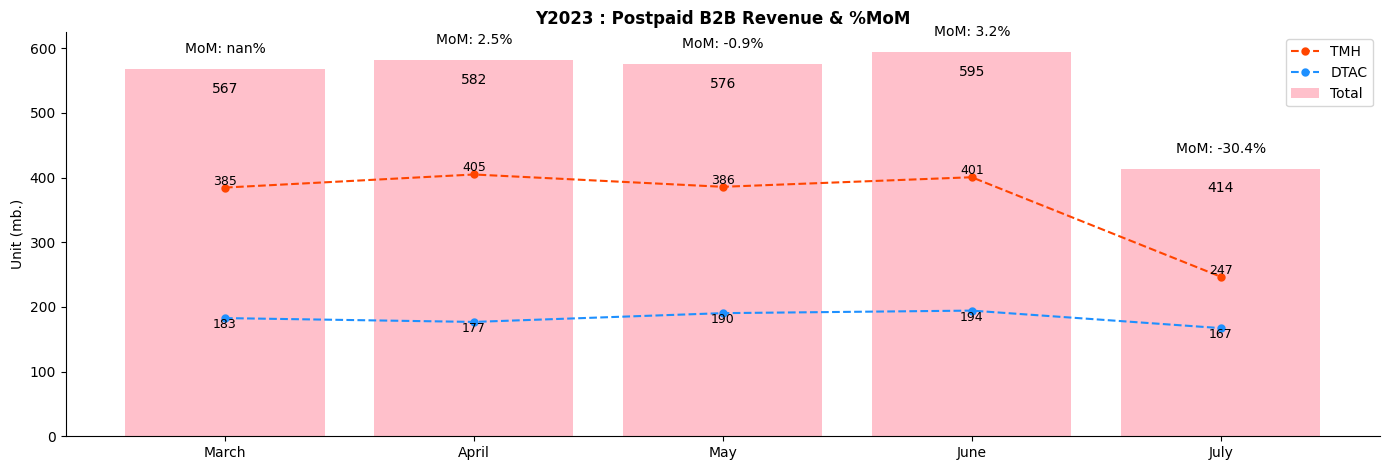

In [26]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : {v_product} Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, unit_mb(y_mth_act), label='Total', color='pink')
plt.plot(x_mth_axis, unit_mb(y_mth_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_mth_axis, unit_mb(y_mth_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+20), ha='center', va='bottom')
    plt.annotate(format(unit_mb(y_mth_act[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])-20), ha='center', va='top')
    # plt.annotate(f"{format(y_mth_mom_tmh[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])), ha='center', va='bottom', fontsize=9)
    # plt.annotate(f"{format(y_mth_mom_dtac[i],',.1%')}", xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_mth_act_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])), ha='center', va='top', fontsize=9)
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

#### MTH : Postpaid Performance : %Achievement & Gap

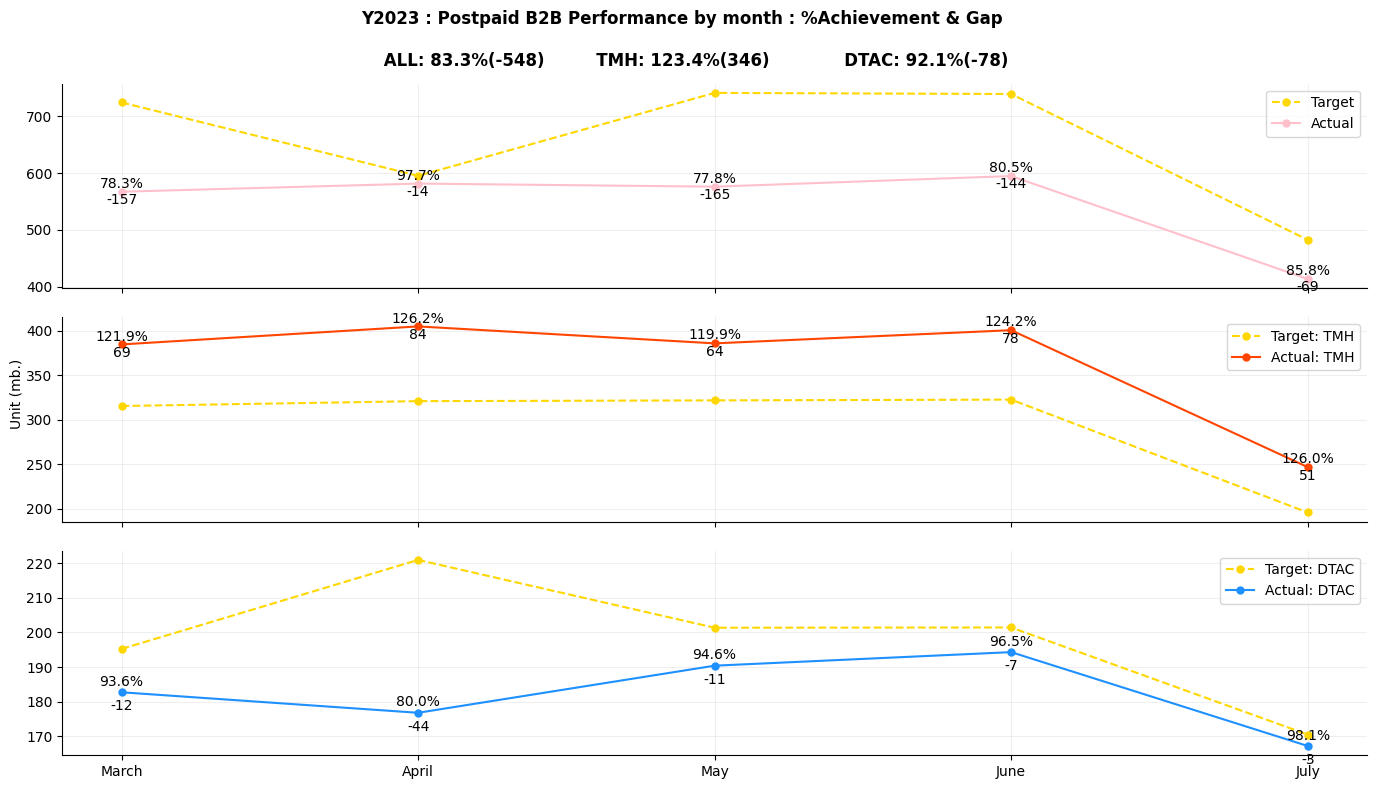

In [27]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} : {v_product} Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_mth_act)/sum(y_mth_tgt),',.1%')}({format(unit_mb(sum(y_mth_gap)),',.0f')}) \
        TMH: {format(sum(y_mth_act_tmh)/sum(y_mth_tgt_tmh),',.1%')}({format(unit_mb(sum(y_mth_gap_tmh)),',.0f')}) \
            DTAC: {format(sum(y_mth_act_dtac)/sum(y_mth_tgt_dtac),',.1%')}({format(unit_mb(sum(y_mth_gap_dtac)),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, unit_mb(y_mth_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, unit_mb(y_mth_act), marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])+1), ha='center', va='bottom')
    ax1.annotate(format(unit_mb(y_mth_gap[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act[i])-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, unit_mb(y_mth_tgt_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, unit_mb(y_mth_act_tmh), marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_tmh[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])+1), ha='center', va='bottom')
    ax2.annotate(format(unit_mb(y_mth_gap_tmh[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_tmh[i])-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, unit_mb(y_mth_tgt_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, unit_mb(y_mth_act_dtac), marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_dtac[i],',.1%'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])+1), ha='center', va='bottom')
    ax3.annotate(format(unit_mb(y_mth_gap_dtac[i]),',.0f'), xy=(x_mth_axis[i], unit_mb(y_mth_act_dtac[i])-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

## ** Weekly **

### WK : Aggregation

In [28]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT': 'sum', 'TGT': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT', 'TGT']]
df_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_wk['%ACHV'] = np.where(df_wk['METRIC_NAME'].str.contains("Churn"), -((df_wk['ACT']/df_wk['TGT'])-1), df_wk['ACT']/df_wk['TGT']) 
df_wk['GAP'] = df_wk['ACT'] - df_wk['TGT']
df_wk['LAST_ACT'] = df_wk.groupby('METRIC_CD')['ACT'].shift()
df_wk['DIFF'] = df_wk['ACT'] - df_wk['LAST_ACT']
df_wk['%WOW'] = (df_wk['ACT'] / df_wk['LAST_ACT']) - 1

# df_wk.to_excel('df_wk.xlsx')
df_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%WOW
186,TB2S020200,Postpaid Churn Subs B2B : TMH,2023027,27,S,12696.0,2352.0,-4.397959,10344.0,1378.0,11318.0,8.213353
187,TB2S020200,Postpaid Churn Subs B2B : TMH,2023028,28,S,2813.0,2016.0,-0.395337,797.0,12696.0,-9883.0,-0.778434
188,TB2S020200,Postpaid Churn Subs B2B : TMH,2023029,29,S,0.0,0.0,NaN,0.0,2813.0,-2813.0,-1.000000


In [29]:
''' Pivot by KPIS '''

df_wk_agg = df_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                        values=['ACT', 'TGT', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_wk_agg.tail(3)

TM_KEY_WK WK_LABEL              ACT                  \
METRIC_NAME                    ACTIVATION_TOTAL ACTIVATION_DTAC   
18            2023027       27           4846.0          2326.0   
19            2023028       28           5778.0          2126.0   
20            2023029       29              0.0             0.0   

                                                                        \
METRIC_NAME ACTIVATION_TMH CHRN_TOTAL CHRN_DTAC CHRN_TMH     REV_TOTAL   
18                  2520.0    14957.0    2261.0  12696.0  1.483557e+07   
19                  3652.0     4391.0    1627.0   2813.0  1.092480e+08   
20                    13.0        0.0       0.0      0.0  0.000000e+00   

                           ...          DIFF             %WOW                  \
METRIC_NAME      REV_DTAC  ...       REV_TMH ACTIVATION_TOTAL ACTIVATION_DTAC   
18           8.777505e+06  ... -2.027674e+08        -0.335436        0.052489   
19           1.296300e+07  ...  9.022697e+07         0.192324       -0.085985   
20           0.000000e+00  ... -9.628503e+07        -1.000000       -1.000000   

                                                                               \
METRIC_NAME ACTIVATION_TMH CHRN_TOTAL CHRN_DTAC  CHRN_TMH REV_TOTAL  REV_DTAC   
18               -0.504132   3.186118  0.030068  8.213353 -0.959386 -0.943898   
19                0.449206  -0.706425 -0.280407 -0.778434  6.363927  0.476843   
20               -0.996440  -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   

                        
METRIC_NAME    REV_TMH  
18           -0.970990  
19           14.893705  
20           -1.000000  

[3 rows x 65 columns]

In [30]:
''' WTD Values '''

df_last_wk = df_day_agg[df_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT', 'TGT']]
day_cnt_curr_wk = len(df_day_agg[(df_day_agg['TM_KEY_WK']==curr_wk) & (df_day_agg['ACT']['REV_TOTAL']>0)]['TM_KEY_DAY'].unique())

wtd_last_act = (df_last_wk['ACT']['REV_TOTAL'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_day_agg[df_day_agg['TM_KEY_WK']==curr_wk]['ACT']['REV_TOTAL'].sum()
wtd_tgt = df_day_agg[df_day_agg['TM_KEY_WK']==curr_wk]['TGT']['REV_TOTAL'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_10792\766515197.py:9: RuntimeWarning: invalid value encountered in scalar divide
  wtd_achv = wtd_act / wtd_tgt
C:\Users\Narut4\AppData\Local\Temp\ipykernel_10792\766515197.py:10: RuntimeWarning: invalid value encountered in scalar divide
  wtd_wow = (wtd_act / wtd_last_act) - 1


In [31]:
''' Week Chart Values '''

x_wk = df_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Values '''
y_wk_act = df_wk_agg['ACT']['REV_TOTAL']
y_wk_act_dtac = df_wk_agg['ACT']['REV_DTAC']
y_wk_act_tmh = df_wk_agg['ACT']['REV_TMH']
y_wk_tgt = df_wk_agg['TGT']['REV_TOTAL']
y_wk_tgt_dtac = df_wk_agg['TGT']['REV_DTAC']
y_wk_tgt_tmh = df_wk_agg['TGT']['REV_TMH']
y_wk_achv = df_wk_agg['%ACHV']['REV_TOTAL']
y_wk_achv_dtac = df_wk_agg['%ACHV']['REV_DTAC']
y_wk_achv_tmh = df_wk_agg['%ACHV']['REV_TMH']
y_wk_gap = df_wk_agg['GAP']['REV_TOTAL']
y_wk_gap_dtac = df_wk_agg['GAP']['REV_DTAC']
y_wk_gap_tmh = df_wk_agg['GAP']['REV_TMH']
y_wk_diff = df_wk_agg['DIFF']['REV_TOTAL']
y_wk_diff_dtac = df_wk_agg['DIFF']['REV_DTAC']
y_wk_diff_tmh = df_wk_agg['DIFF']['REV_TMH']
y_wk_last_act = df_wk_agg['LAST_ACT']['REV_TOTAL']
y_wk_last_act_dtac = df_wk_agg['LAST_ACT']['REV_DTAC']
y_wk_last_act_tmh = df_wk_agg['LAST_ACT']['REV_TMH']
y_wk_wow = df_wk_agg['%WOW']['REV_TOTAL']
y_wk_wow_dtac = df_wk_agg['%WOW']['REV_DTAC']
y_wk_wow_tmh = df_wk_agg['%WOW']['REV_TMH']

### WK : Visualizations

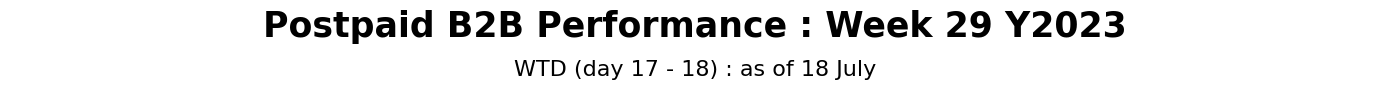

In [32]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) : as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

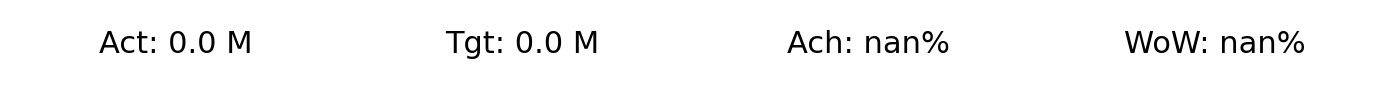

In [33]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(wtd_act),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(wtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

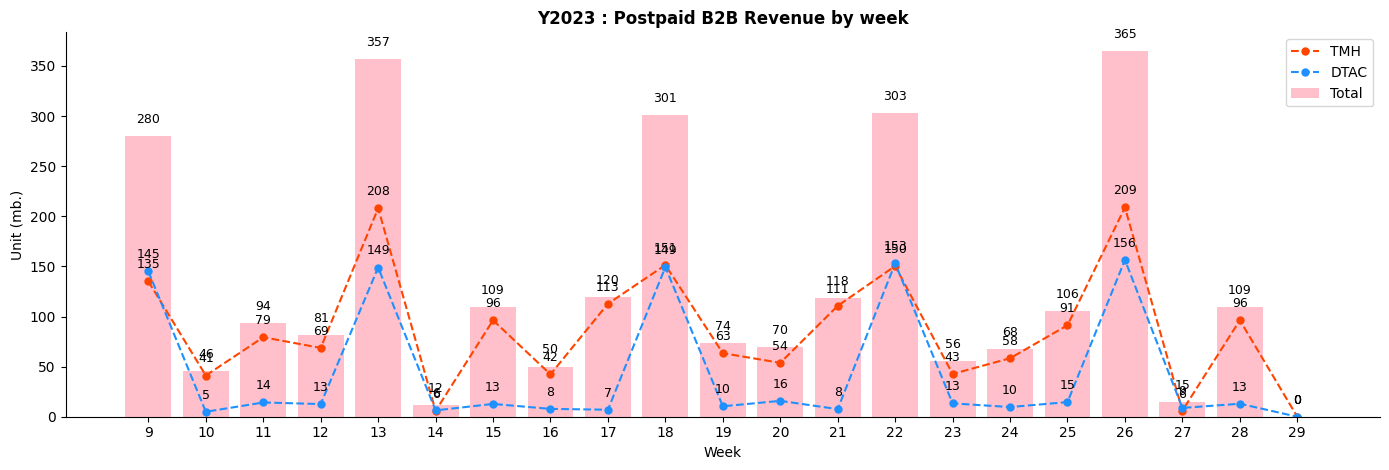

In [34]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} : {v_product} Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_wk_axis, unit_mb(y_wk_act), label='Total', color='pink')
plt.plot(x_wk_axis, unit_mb(y_wk_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, unit_mb(y_wk_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(format(unit_mb(y_wk_act[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_tmh[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_wk_act_dtac[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

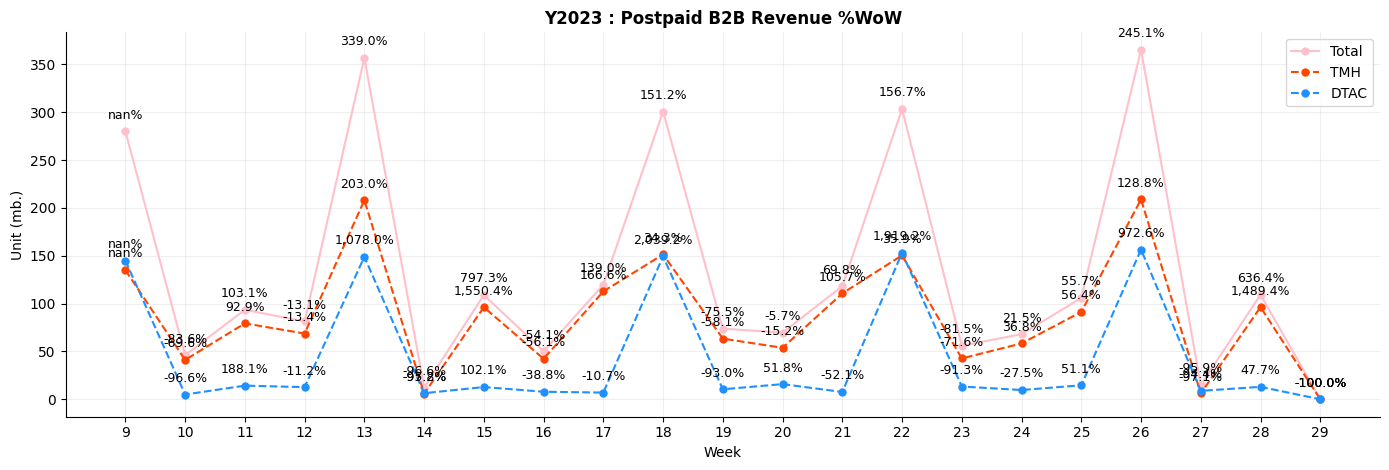

In [35]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} : {v_product} Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_wk_axis, unit_mb(y_wk_act), marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_wk_axis, unit_mb(y_wk_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, unit_mb(y_wk_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(f"{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_tmh[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_dtac[i],',.1%')}", xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

#### WK : Postpaid Performance : %Achievement & Gap

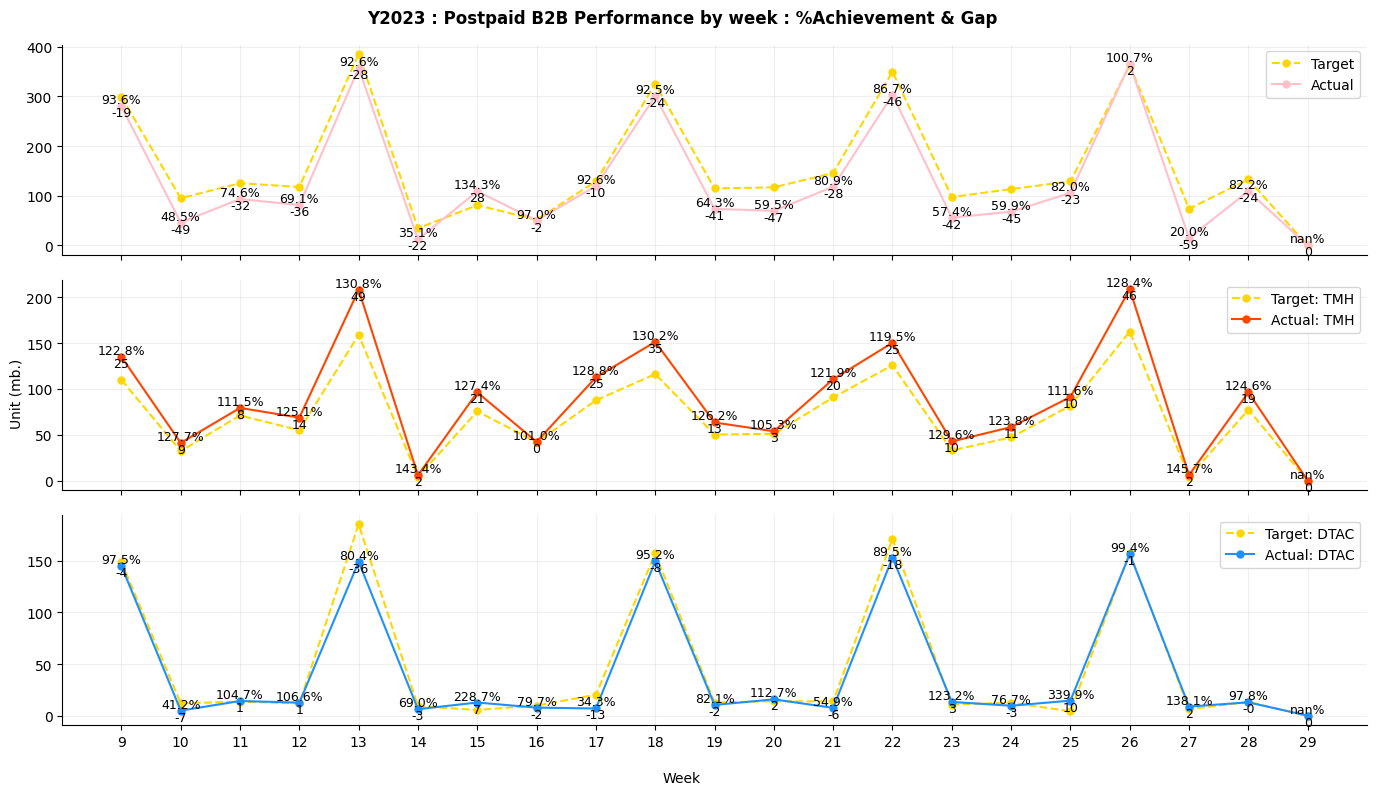

In [36]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} : {v_product} Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_wk_axis, unit_mb(y_wk_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_wk_axis, unit_mb(y_wk_act), marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_wk_axis:
    ax1.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(unit_mb(y_wk_gap[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act[i])), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_wk_axis, unit_mb(y_wk_tgt_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_wk_axis, unit_mb(y_wk_act_tmh), marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_wk_axis:
    ax2.annotate(format(y_wk_achv_tmh[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(unit_mb(y_wk_gap_tmh[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_tmh[i])), ha='center', va='top', fontsize=9)

''' ax3 '''
ax3.plot(x_wk_axis, unit_mb(y_wk_tgt_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_wk_axis, unit_mb(y_wk_act_dtac), marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_wk_axis:
    ax3.annotate(format(y_wk_achv_dtac[i],',.1%'), xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(unit_mb(y_wk_gap_dtac[i]),',.0f'), xy=(x_wk_axis[i], unit_mb(y_wk_act_dtac[i])), ha='center', va='top', fontsize=9)

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_wk_axis, x_wk)
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [37]:
''' Create Dataframe '''

df_day_curr_mth = df_day_agg[df_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_day_last_mth = df_day_agg[(df_day_agg['TM_KEY_MTH']==last_mth) & (df_day_agg['DAY_LABEL'].isin(df_day_curr_mth['DAY_LABEL']))][['TM_KEY_DAY', 'DAY_LABEL', 'ACT']].reset_index()

df_day_curr_mth_clean = df_day_curr_mth[df_day_curr_mth['ACT']['REV_TOTAL'] > 0].reset_index()

df_day_curr_day = df_day_curr_mth_clean.loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_day_last_day = df_day_curr_mth_clean.shift().loc[df_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [38]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_day_last_day['ACT']['REV_TOTAL'].sum()

''' TOTAL : Values '''
dtd_rev = df_day_curr_day['ACT']['REV_TOTAL'].sum()
dtd_tgt = df_day_curr_day['TGT']['REV_TOTAL'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_day_last_day['ACT']['REV_TOTAL'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

In [39]:
''' Day Chart Values '''

x_day = df_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Values '''
y_day_act = df_day_curr_mth['ACT']['REV_TOTAL']
y_day_act_dtac = df_day_curr_mth['ACT']['REV_DTAC']
y_day_act_tmh = df_day_curr_mth['ACT']['REV_TMH']
y_day_tgt = df_day_curr_mth['TGT']['REV_TOTAL']
y_day_tgt_dtac = df_day_curr_mth['TGT']['REV_DTAC']
y_day_tgt_tmh = df_day_curr_mth['TGT']['REV_TMH']
y_day_achv = df_day_curr_mth['%ACHV']['REV_TOTAL']
y_day_achv_dtac = df_day_curr_mth['%ACHV']['REV_DTAC']
y_day_achv_tmh = df_day_curr_mth['%ACHV']['REV_TMH']
y_day_gap = df_day_curr_mth['GAP']['REV_TOTAL']
y_day_gap_dtac = df_day_curr_mth['GAP']['REV_DTAC']
y_day_gap_tmh = df_day_curr_mth['GAP']['REV_TMH']
y_day_diff = df_day_curr_mth['DIFF']['REV_TOTAL']
y_day_diff_dtac = df_day_curr_mth['DIFF']['REV_DTAC']
y_day_diff_tmh = df_day_curr_mth['DIFF']['REV_TMH']
y_day_last_act = df_day_last_mth['ACT']['REV_TOTAL']
y_day_last_act_dtac = df_day_last_mth['ACT']['REV_DTAC']
y_day_last_act_tmh = df_day_last_mth['ACT']['REV_TMH']
y_day_dod = df_day_curr_mth['%DOD']['REV_TOTAL']
y_day_dod_dtac = df_day_curr_mth['%DOD']['REV_DTAC']
y_day_dod_tmh = df_day_curr_mth['%DOD']['REV_TMH']

### DAY : Visualizations

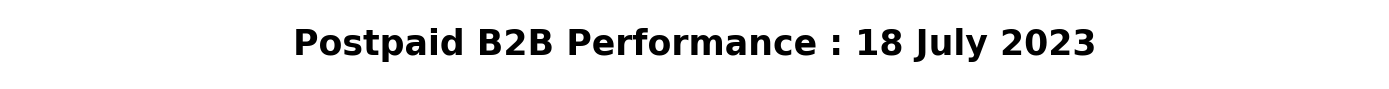

In [40]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"{v_product} Performance : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

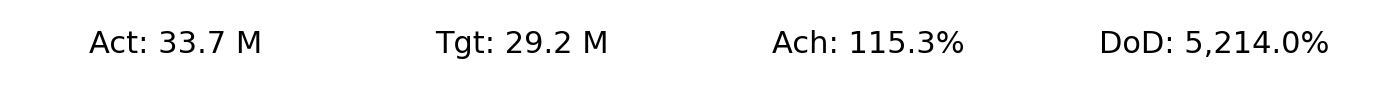

In [41]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(unit_mb(dtd_rev),',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(unit_mb(dtd_tgt),',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

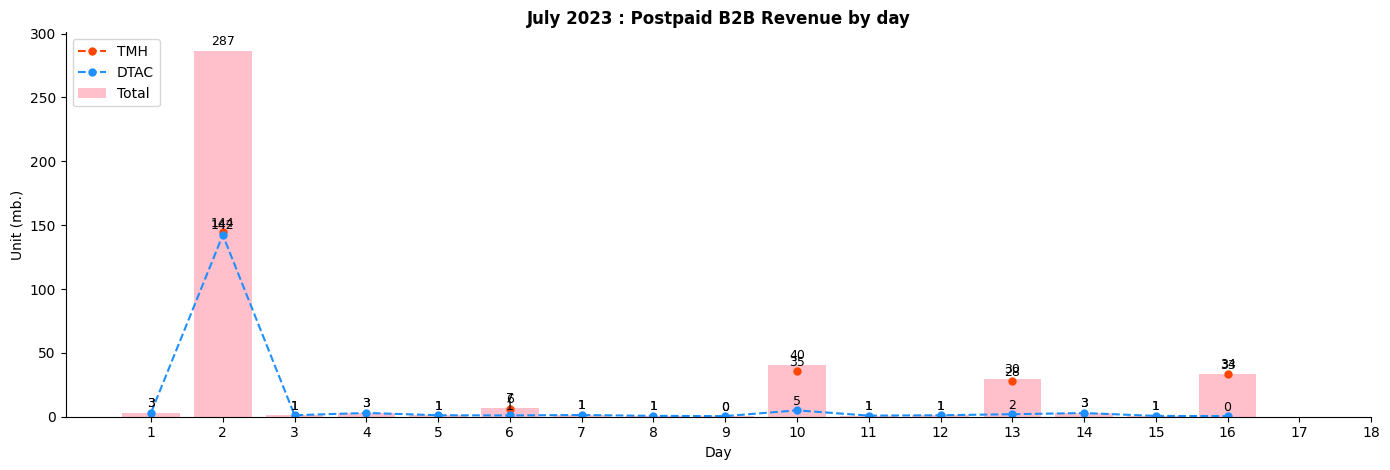

In [42]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : {v_product} Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, unit_mb(y_day_act), label='Total', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, unit_mb(y_day_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(format(unit_mb(y_day_act[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_tmh[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_day_act_dtac[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])+2), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

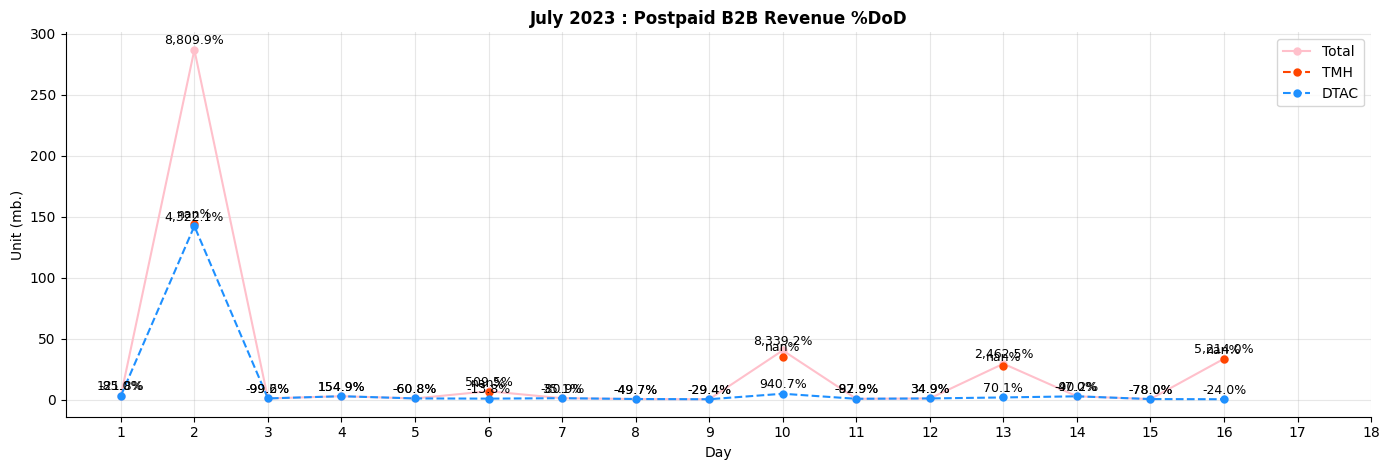

In [43]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : {v_product} Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, unit_mb(y_day_act), marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, unit_mb(y_day_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(f"{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], unit_mb(y_day_act[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_tmh[i],',.1%')}", xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_dtac[i],',.1%')}", xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])+2), ha='center', va='bottom', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### DAY : Postpaid Performance : %Achievement & Gap

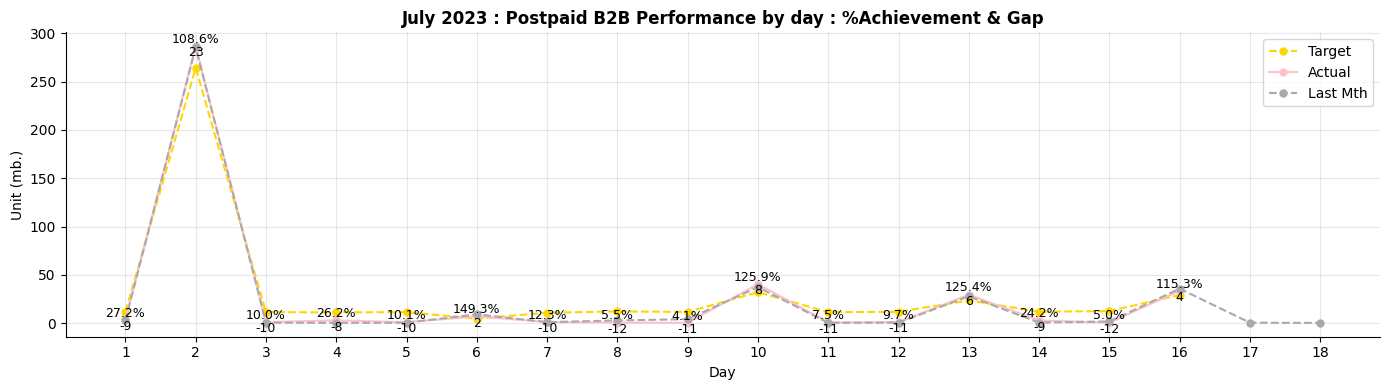

In [44]:
''' Peformance : %Achievement & Gap : Day Chart '''

plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : {v_product} Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_day_axis, unit_mb(y_day_tgt), marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, unit_mb(y_day_act), marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_day_axis, unit_mb(y_day_last_act), marker='.', linestyle='dashed', markeredgewidth=3, label='Last Mth', color='darkgray')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_act[i])+0.2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(unit_mb(y_day_gap[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act[i])-0.2), ha='center', va='top', fontsize=9)

plt.xlabel('Day')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

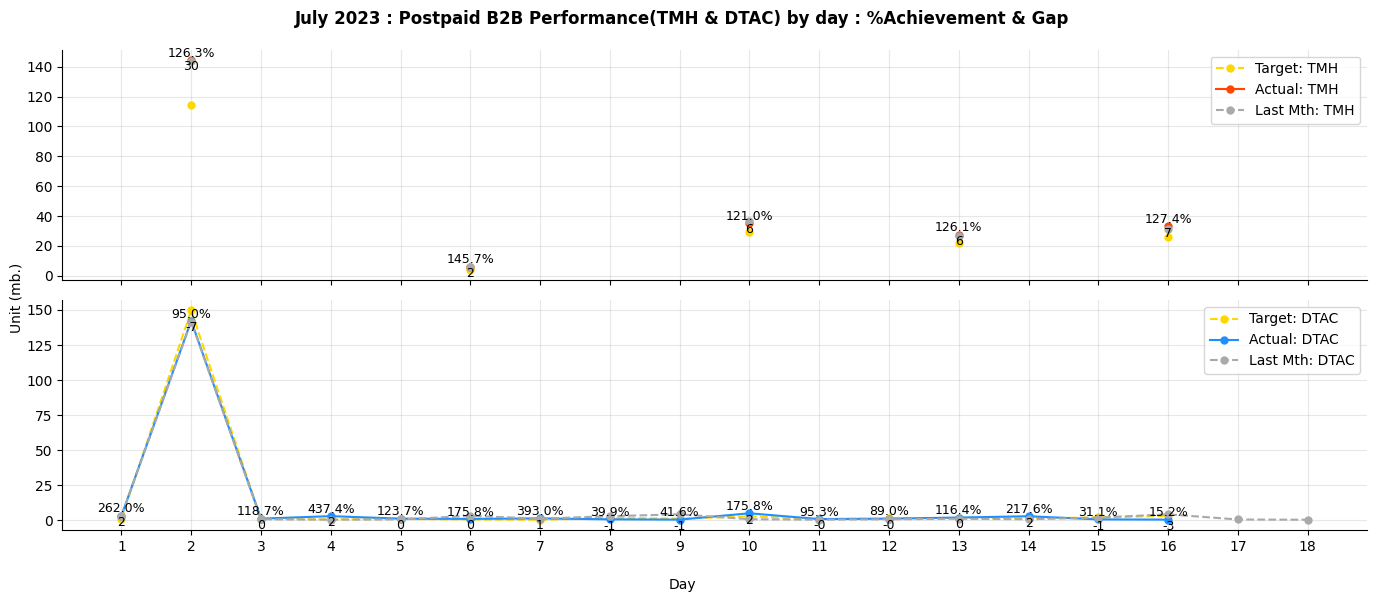

In [45]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : {v_product} Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_day_axis, unit_mb(y_day_tgt_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax1.plot(x_day_axis, unit_mb(y_day_act_tmh), marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax1.plot(x_day_axis, unit_mb(y_day_last_act_tmh), marker='.', linestyle='dashed', markeredgewidth=3, label='Last Mth: TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_day_axis:
    ax1.annotate(format(y_day_achv_tmh[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])+0.2), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(unit_mb(y_day_gap_tmh[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_tmh[i])-0.2), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_day_axis, unit_mb(y_day_tgt_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax2.plot(x_day_axis, unit_mb(y_day_act_dtac), marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax2.plot(x_day_axis, unit_mb(y_day_last_act_dtac), marker='.', linestyle='dashed', markeredgewidth=3, label='Last Mth: DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_day_axis:
    ax2.annotate(format(y_day_achv_dtac[i],',.1%'), xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])+0.2), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(unit_mb(y_day_gap_dtac[i]),',.0f'), xy=(x_day_axis[i], unit_mb(y_day_act_dtac[i])-0.2), ha='center', va='top', fontsize=9)

fig.supxlabel('Day', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_day_axis, x_day)
plt.show()